In [1]:
%load_ext autoreload
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter

from matplotlib import rcParams
rcParams['figure.figsize'] = 16, 12
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']

# Custom Code Import
%autoreload 2
from fooof.fooof import *

def group_three(vec):
    """Takes array of inputs, groups by three."""
    
    return [list(vec[i:i+3]) for i in range(0, len(vec), 3)]

def rmse(preds, target):
    """Calculate root mean squared error."""
    
    return np.sqrt(((preds - target) ** 2).mean())

def abs_err_freq(preds, target):
    """Calculate the absolute error across frequencies."""
    
    return np.abs(preds - target)

/Users/Voytek/anaconda/envs/py3k/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import os
my_dir = '/Users/Voytek/fooof/data'
for file in os.listdir(my_dir):
    if file.endswith('.npy'):
        pass
#         print(os.path.join(my_dir, file))


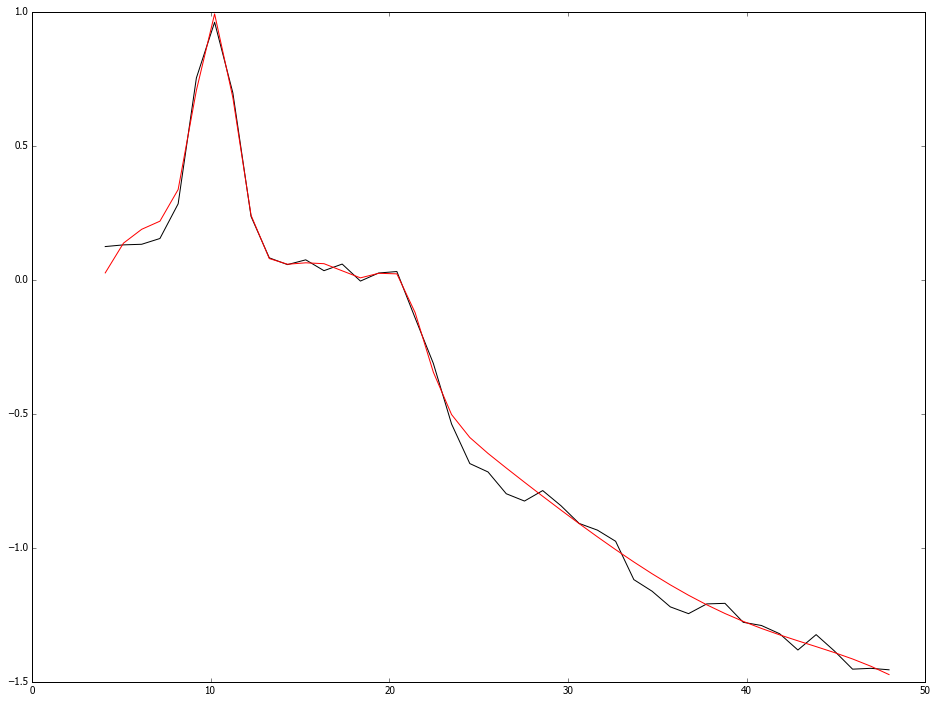

In [7]:
# # syn
# file = '1.npy'
# filename = os.path.join(my_dir, file)
# freq_range = [3, 50]
# psd_array = np.load(filename)
# psd_array = np.log10(psd_array)
# range_size = (np.size(range(freq_range[1]))-0)-(np.size(range(freq_range[0]))+0)
# freqs = np.linspace(freq_range[0], freq_range[1], range_size)-1
# # Fix up PSD
# psd_array = np.vstack((psd_array, psd_array))

# eeg
file = '62.npy'
filename = os.path.join(my_dir, file)
freq_range = [0, 49]
psd_array = np.load(filename)
psd_array = np.log10(psd_array)
range_size = (np.size(range(freq_range[1]))-0)-(np.size(range(freq_range[0]))+0)
freqs = np.linspace(freq_range[0], freq_range[1], range_size)
# Fix up PSD
# psd_array = np.log10(psd_array)
psd_array = np.vstack((psd_array, psd_array))
psd_array = psd_array.T

# # lfp
# file = 'i003_ch08_raw.npy'
# filename = os.path.join(my_dir, file)
# freq_range = [0, 49]
# psd_array = np.load(filename)
# psd_array = np.log10(psd_array)
# range_size = (np.size(range(freq_range[1]))-0)-(np.size(range(freq_range[0]))+0)
# freqs = np.linspace(freq_range[0], freq_range[1], range_size)
# # Fix up PSD
# psd_array = np.log10(psd_array)
# psd_array = np.vstack((psd_array, psd_array))
# psd_array = psd_array.T



# FOOOF SETTINGS
window_around_max = 4
number_of_gaussians = 6
cut_freqs = [2, 49]

# Run FOOOF
p_flat_real, frequency_vector, trimmed_psd, psd_fit, background_fit, gaussian_fit, background_params, oscillation_params = \
    fooof(freqs, psd_array, cut_freqs, number_of_gaussians, window_around_max)

while np.argmax(abs_err_freq(psd_fit, trimmed_psd)) == 0:
    cut_freqs[0] += 0.5
    p_flat_real, frequency_vector, trimmed_psd, psd_fit, background_fit, gaussian_fit, background_params, oscillation_params = \
        fooof(freqs, psd_array, cut_freqs, number_of_gaussians, window_around_max)

guess = oscillation_params

if guess:
    guess = sorted(guess, key=itemgetter(1), reverse=True)

    try:
        popt, _ = curve_fit(gaussian_function, frequency_vector, p_flat_real, p0=guess, maxfev=5000)
        multi_fit = gaussian_function(frequency_vector, *popt)
        psd_fit = multi_fit + background_fit
        
        
        overlap = group_three(popt)
        overlap = sorted(overlap, key=itemgetter(0))

        # clean up unrealistic oscillations
        new_list = np.empty((0,3))
        list_length = np.shape(overlap)[0]
        for i in range(list_length):
            keep_check = \
                ((overlap[i][0]-(overlap[i][2])) > cut_freqs[0]) & \
                ((overlap[i][0]+(overlap[i][2])) < cut_freqs[1]) & \
                (overlap[i][2] > 0.5) & \
                (overlap[i][2] < 5.) & \
                (overlap[i][1] > 0)
            if keep_check:
                new_list = np.vstack((new_list, overlap[i]))

        overlap = np.copy(new_list)
        guess = np.copy(overlap)  
        
        # for i in range(np.shape(guess)[0]):
        #     print((guess[i][2]*(np.sqrt(2*np.pi)))*guess[i][1])

        popt, _ = curve_fit(gaussian_function, frequency_vector, p_flat_real, p0=guess, maxfev=5000)
        multi_fit = gaussian_function(frequency_vector, *popt)
        psd_fit = multi_fit + background_fit
        
    except:
        pass

plt.plot(frequency_vector, trimmed_psd, 'k')
plt.plot(frequency_vector, psd_fit, 'r')
plt.show()

In [ ]:
# LFP

import os

col_cf = []
col_bw = []
col_file = []
my_dir = '/Users/Voytek/fooof/data'
for file in os.listdir(my_dir):
    if file.endswith('.npy'):
        # lfp
        filename = os.path.join(my_dir, file)
        freq_range = [0, 49]
        psd_array = np.load(filename)
        psd_array = np.log10(psd_array)
        range_size = (np.size(range(freq_range[1]))-0)-(np.size(range(freq_range[0]))+0)
        freqs = np.linspace(freq_range[0], freq_range[1], range_size)
        # Fix up PSD
        psd_array = np.log10(psd_array)
        psd_array = np.vstack((psd_array, psd_array))
        psd_array = psd_array.T

        # FOOOF SETTINGS
        window_around_max = 4
        number_of_gaussians = 6
        cut_freqs = [2, 49]

        # Run FOOOF
        p_flat_real, frequency_vector, trimmed_psd, psd_fit, background_fit, gaussian_fit, background_params, oscillation_params = \
            fooof(freqs, psd_array, cut_freqs, number_of_gaussians, window_around_max)

        while np.argmax(abs_err_freq(psd_fit, trimmed_psd)) == 0:
            cut_freqs[0] += 0.5
            p_flat_real, frequency_vector, trimmed_psd, psd_fit, background_fit, gaussian_fit, background_params, oscillation_params = \
                fooof(freqs, psd_array, cut_freqs, number_of_gaussians, window_around_max)

        guess = oscillation_params

        if guess:
            guess = sorted(guess, key=itemgetter(1), reverse=True)

            try:
                popt, _ = curve_fit(gaussian_function, frequency_vector, p_flat_real, p0=guess, maxfev=5000)
                multi_fit = gaussian_function(frequency_vector, *popt)
                psd_fit = multi_fit + background_fit


                overlap = group_three(popt)
                overlap = sorted(overlap, key=itemgetter(0))

                # clean up unrealistic oscillations
                new_list = np.empty((0,3))
                list_length = np.shape(overlap)[0]
                for i in range(list_length):
                    keep_check = \
                        ((overlap[i][0]-(overlap[i][2])) > cut_freqs[0]) & \
                        ((overlap[i][0]+(overlap[i][2])) < cut_freqs[1]) & \
                        (overlap[i][2] > 0.5) & \
                        (overlap[i][2] < 5.) & \
                        (overlap[i][1] > 0)
                    if keep_check:
                        new_list = np.vstack((new_list, overlap[i]))

                overlap = np.copy(new_list)
                guess = np.copy(overlap)  

                # for i in range(np.shape(guess)[0]):
                #     print((guess[i][2]*(np.sqrt(2*np.pi)))*guess[i][1])

                popt, _ = curve_fit(gaussian_function, frequency_vector, p_flat_real, p0=guess, maxfev=5000)
                multi_fit = gaussian_function(frequency_vector, *popt)
                psd_fit = multi_fit + background_fit
                
                popt = group_three(popt)
                
                for i in range(np.shape(popt)[0]):
                    col_cf.append(popt[i][0])
                    col_bw.append(popt[i][2])
                    col_file.append(file)

            except:
                pass

import pandas as pd
d = {'file': col_file, 'cf': col_cf, 'bw': col_bw}
df = pd.DataFrame(data=d)
df = df[['file', 'cf', 'bw']]
df.to_csv('lfp.csv', sep=',', index = False)

In [8]:
# EEG

import os

col_cf = []
col_bw = []
col_file = []
my_dir = '/Users/Voytek/fooof/data'
for file in os.listdir(my_dir):
    if file.endswith('.npy'):
        # eeg
        filename = os.path.join(my_dir, file)
        freq_range = [0, 49]
        psd_array = np.load(filename)
        psd_array = np.log10(psd_array)
        range_size = (np.size(range(freq_range[1]))-0)-(np.size(range(freq_range[0]))+0)
        freqs = np.linspace(freq_range[0], freq_range[1], range_size)
        # Fix up PSD
        # psd_array = np.log10(psd_array)
        psd_array = np.vstack((psd_array, psd_array))
        psd_array = psd_array.T

        # FOOOF SETTINGS
        window_around_max = 4
        number_of_gaussians = 6
        cut_freqs = [2, 49]

        # Run FOOOF
        p_flat_real, frequency_vector, trimmed_psd, psd_fit, background_fit, gaussian_fit, background_params, oscillation_params = \
            fooof(freqs, psd_array, cut_freqs, number_of_gaussians, window_around_max)

        while np.argmax(abs_err_freq(psd_fit, trimmed_psd)) == 0:
            cut_freqs[0] += 0.5
            p_flat_real, frequency_vector, trimmed_psd, psd_fit, background_fit, gaussian_fit, background_params, oscillation_params = \
                fooof(freqs, psd_array, cut_freqs, number_of_gaussians, window_around_max)

        guess = oscillation_params

        if guess:
            guess = sorted(guess, key=itemgetter(1), reverse=True)

            try:
                popt, _ = curve_fit(gaussian_function, frequency_vector, p_flat_real, p0=guess, maxfev=5000)
                multi_fit = gaussian_function(frequency_vector, *popt)
                psd_fit = multi_fit + background_fit


                overlap = group_three(popt)
                overlap = sorted(overlap, key=itemgetter(0))

                # clean up unrealistic oscillations
                new_list = np.empty((0,3))
                list_length = np.shape(overlap)[0]
                for i in range(list_length):
                    keep_check = \
                        ((overlap[i][0]-(overlap[i][2])) > cut_freqs[0]) & \
                        ((overlap[i][0]+(overlap[i][2])) < cut_freqs[1]) & \
                        (overlap[i][2] > 0.5) & \
                        (overlap[i][2] < 5.) & \
                        (overlap[i][1] > 0)
                    if keep_check:
                        new_list = np.vstack((new_list, overlap[i]))

                overlap = np.copy(new_list)
                guess = np.copy(overlap)  

                # for i in range(np.shape(guess)[0]):
                #     print((guess[i][2]*(np.sqrt(2*np.pi)))*guess[i][1])

                popt, _ = curve_fit(gaussian_function, frequency_vector, p_flat_real, p0=guess, maxfev=5000)
                multi_fit = gaussian_function(frequency_vector, *popt)
                psd_fit = multi_fit + background_fit
                
                popt = group_three(popt)
                
                for i in range(np.shape(popt)[0]):
                    col_cf.append(popt[i][0])
                    col_bw.append(popt[i][2])
                    col_file.append(file)

            except:
                pass

import pandas as pd
d = {'file': col_file, 'cf': col_cf, 'bw': col_bw}
df = pd.DataFrame(data=d)
df = df[['file', 'cf', 'bw']]
df.to_csv('eeg.csv', sep=',', index = False)

/Users/Voytek/anaconda/envs/py3k/lib/python3.5/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [3]:
# SYN

import os

col_cf = []
col_bw = []
col_file = []
my_dir = '/Users/Voytek/fooof/data'
for file in os.listdir(my_dir):
    if file.endswith('.npy'):
        # syn
        filename = os.path.join(my_dir, file)
        freq_range = [3, 50]
        psd_array = np.load(filename)
        psd_array = np.log10(psd_array)
        range_size = (np.size(range(freq_range[1]))-0)-(np.size(range(freq_range[0]))+0)
        freqs = np.linspace(freq_range[0], freq_range[1], range_size)-1
        # Fix up PSD
        psd_array = np.vstack((psd_array, psd_array))

        # FOOOF SETTINGS
        window_around_max = 4
        number_of_gaussians = 6
        cut_freqs = [2, 49]

        # Run FOOOF
        p_flat_real, frequency_vector, trimmed_psd, psd_fit, background_fit, gaussian_fit, background_params, oscillation_params = \
            fooof(freqs, psd_array, cut_freqs, number_of_gaussians, window_around_max)

        while np.argmax(abs_err_freq(psd_fit, trimmed_psd)) == 0:
            cut_freqs[0] += 0.5
            p_flat_real, frequency_vector, trimmed_psd, psd_fit, background_fit, gaussian_fit, background_params, oscillation_params = \
                fooof(freqs, psd_array, cut_freqs, number_of_gaussians, window_around_max)

        guess = oscillation_params

        if guess:
            guess = sorted(guess, key=itemgetter(1), reverse=True)

            try:
                popt, _ = curve_fit(gaussian_function, frequency_vector, p_flat_real, p0=guess, maxfev=5000)
                multi_fit = gaussian_function(frequency_vector, *popt)
                psd_fit = multi_fit + background_fit


                overlap = group_three(popt)
                overlap = sorted(overlap, key=itemgetter(0))

                # clean up unrealistic oscillations
                new_list = np.empty((0,3))
                list_length = np.shape(overlap)[0]
                for i in range(list_length):
                    keep_check = \
                        ((overlap[i][0]-(overlap[i][2])) > cut_freqs[0]) & \
                        ((overlap[i][0]+(overlap[i][2])) < cut_freqs[1]) & \
                        (overlap[i][2] > 0.5) & \
                        (overlap[i][2] < 5.) & \
                        (overlap[i][1] > 0)
                    if keep_check:
                        new_list = np.vstack((new_list, overlap[i]))

                overlap = np.copy(new_list)
                guess = np.copy(overlap)  

                # for i in range(np.shape(guess)[0]):
                #     print((guess[i][2]*(np.sqrt(2*np.pi)))*guess[i][1])

                popt, _ = curve_fit(gaussian_function, frequency_vector, p_flat_real, p0=guess, maxfev=5000)
                multi_fit = gaussian_function(frequency_vector, *popt)
                psd_fit = multi_fit + background_fit
                
                popt = group_three(popt)
                
                for i in range(np.shape(popt)[0]):
                    col_cf.append(popt[i][0])
                    col_bw.append(popt[i][2])
                    col_file.append(file)

            except:
                pass

import pandas as pd
d = {'file': col_file, 'cf': col_cf, 'bw': col_bw}
df = pd.DataFrame(data=d)
df = df[['file', 'cf', 'bw']]
df.to_csv('syn.csv', sep=',', index = False)

/Users/Voytek/anaconda/envs/py3k/lib/python3.5/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/Voytek/anaconda/envs/py3k/lib/python3.5/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/Voytek/anaconda/envs/py3k/lib/python3.5/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/Voytek/anaconda/envs/py3k/lib/python3.5/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
